In [1]:
# Default parameters
Vth = 1  # spiking threshold
dt = 0.1e-3  # integration time step - s
T = 20e-3  # membrane time constant - s
N = 1000  # number of neurons in each population
K = 100  # nmber of presynaptic partners (per neuron) from each population
rX = 10  # firing rate of the Poisson neurons in population X

In [30]:
# Helper functions
import numpy as np
from numpy.random import binomial
import matplotlib.pyplot as plt
%matplotlib inline

def generate_poisson_spikes(dur, num, delta = dt, rate = rX):
    return 1/dt * binomial(1, rX * delta, (num, int(dur/dt)))

def plot_spike_trains(poisson_activity, dur, ylim, delta = dt):
    spike_trains = [(delta*t, i+1) for t in range(poisson_activity.shape[1]) for i in range(poisson_activity.shape[0]) if poisson_activity[i,t]>0]
    x, y = zip(*spike_trains)
    plt.scatter(x, y, marker="|")
    plt.xlim(0, dur)
    plt.ylim(0, ylim)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Neuron")

def plot_membrane_potential(V, dur, delta=dt):
    t = np.linspace(0, dur, int(dur/delta) + 1)
    plt.plot(t, V)
    plt.xlim(0, dur)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Membrane potential")
    
# def LIF(w, Sj, dur, spike_and_reset = True, delta = dt):
#     if Sj.shape[0] == 1:
#         return LIF_single_input(w, Sj, dur, spike_and_reset, delta)
#     else:
#         return LIF_multiple_inputs(w, Sj, dur, spike_and_reset, delta)

def LIF_single_input(w, Sj, dur, spike_and_reset = True, delta = dt):
    V = np.zeros(int(dur/delta) + 1)
    # Obtain V through forward Euler integration:
    if spike_and_reset:
        #  if an action potential was fired at time k-1, then set V(k-1) to 0 for the calculation of V(k)
        for k in range(1, len(V)):
            if V[k-1] <= Vth:
                V[k] = V[k-1] + delta * (-V[k-1]/T + w * Sj[k-1])
            else:
                V[k] = delta * w * Sj[k-1]
    else:  # spike-and-reset mechanism has been disabled
        for k in range(1, len(V)):
            V[k] = V[k-1] + delta * (-V[k-1]/T + w * Sj[k-1])
    return V

def LIF_multiple_inputs(w, Sj, dur, spike_and_reset = True, delta = dt):
    S = np.sum(Sj, 0)
    V = np.zeros(int(dur/delta) + 1)
    # Obtain V through forward Euler integration:
    if spike_and_reset:
        #  if an action potential was fired at time k-1, then set V(k-1) to 0 for the calculation of V(k)
        for k in range(1, len(V)):
            if V[k-1] <= Vth:
                V[k] = V[k-1] + delta * (-V[k-1]/T + w * S[k-1])
            else:
                V[k] = delta * w * S[k-1]
    else:  # spike-and-reset mechanism has been disabled
        for k in range(1, len(V)):
            V[k] = V[k-1] + delta * (-V[k-1]/T + w * S[k-1])
    return V

def get_S_from_V(V, threshold = Vth):
    S = [1 if V[k] > threshold else 0 for k in range(1, len(V))]
    return S

### 1. Generating Poisson spike trains

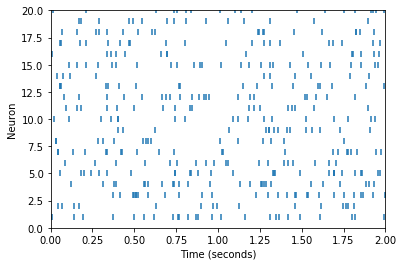

In [3]:
dur = 2.0
x_activity = generate_poisson_spikes(dur, N)
plot_spike_trains(x_activity, dur, 20)

In [4]:
# Sanity check: average number of spikes fired by each neuron should be about 2 * rX = 20
print("Average number of spikes fired by each neuron is ", np.average(dt*np.sum(x_activity, 1)))

Average number of spikes fired by each neuron is  19.884


### 2. Single LIF neuron with one input spike train

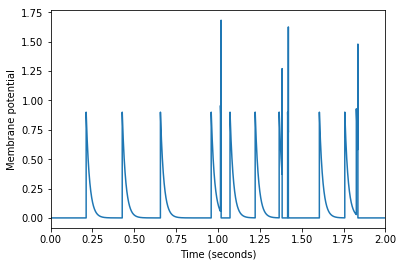

In [21]:
w = 0.9  # Synaptic weight
dur = 2.0
Sj = generate_poisson_spikes(dur, 1)[0]  # one Poisson neuron's activity
# print(Sj)
# print(np.linspace(0, 1, 1/0.5 + 1))
# print(np.zeros(int(1/0.5) + 1))

V = LIF_single_input(w, Sj, dur)
Si = get_S_from_V(V)

plot_membrane_potential(V, dur)

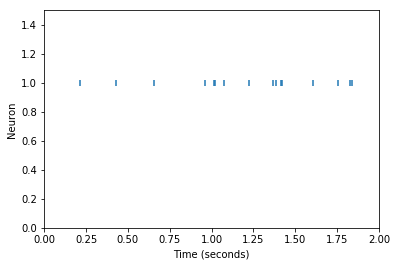

In [31]:
plot_spike_trains(np.array([Sj]), dur, 1.5)

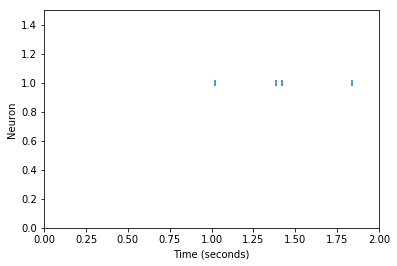

In [32]:
plot_spike_trains(np.array([Si]), dur, 1.5)

### 3. Single LIF neuron with many input spike trains

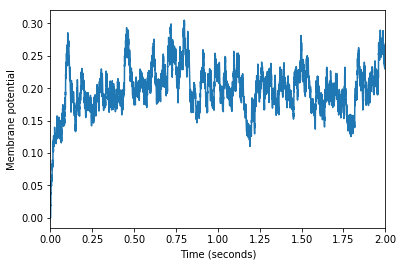

In [35]:
# (a)
# S = np.sum(x_activity(0:K-1,:), 0)  # activity of K independent Poisson neurons
w = 1
dur = 2

S = generate_poisson_spikes(dur, K)
V = LIF_multiple_inputs(w/K, S, dur, spike_and_reset = False)

plot_membrane_potential(V, dur)

In [ ]:
# (b)
m_h = w * rX
var_h = w**2 * rX / K
m_V = m_h * T
var_V = 0

Derivations of quantities in (b)

$
E(h) = \frac{w}{K} * E(\sum_{i=1}^K S_j) = \frac{w}{K} * \sum_{i=1}^K E(S_j) = \frac{w}{K} * K * r_X = w * r_X 
$

$
Var(h) = \frac{w}{K}^2 * Var(\sum_{i=1}^K S_j) = \frac{w}{K}^2 * \sum_{i=1}^K Var(S_j) = \frac{w}{K}^2 * K * r_X = \frac{w^2 * r_X}{K}
$

Derivations for V are given in photo on phone

In [ ]:
# (c)
plt([0:1000], m_h)  # plot m_V as a function of K
plt([0:1000], var_V)  # plot var_V as a function of K


In [ ]:
# (d)

In [ ]:
# (e)

### 4. Single LIF neuron with many E and I Poisson inputs

In [ ]:
# (a)
Se = np.sum(x_activity(0:K-1,:), 0)  # activity of K independent excitory Poisson neurons
Si = np.sum(x_activity(K:2*K-1,:), 0)  # activity of K independent inhibitory Poisson neurons
w = 1
V = [V[k-1] + dt * (-V[k-1]/T + w * Sj[k-1]) for k in range(1, len(V)) if V[k-1] <= Vth else dt * (w * Sj[k-1])]

In [ ]:
# {b)

### 5. Full network

In [ ]:
# synpatic weight parameters
Jee = -1
Jie = 1
Jei = -2
Jii = -1.8
Jex = 1
Jix = 0.8
